# Install Necessary Packages (Only need to do once)

In [1]:
# Install Necessary Packages
! pip install geopandas
! pip install shapely
! pip install opencv-python


In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# Imports

In [6]:
# Importing the toolbox (takes several seconds)
import pandas as pd
import numpy as np
#import pynapple as nap
from pathlib import Path
import os
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple
import shutil
import seaborn as sns
from pylab import *
import os
import geopandas as gpd
import scipy.stats as sp
import time
from datetime import datetime
import deeplabcut
import tensorflow as tf
import keras
os.environ['DLClight'] = 'True'
print(tf.__version__)

from os.path import exists
import csv
import json

# Import dlc_utils
import sys

# Specify path to dlc_utils file
sys.path.append(r'D:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\src\compass_labyrinth\behavior\pose_estimation')

import dlc_utils

2.10.0


### Specify Paths and Other Information

In [11]:
##### CHANGE THE PATHS AS PER USER LOCAL DRIVE

base_path = r'D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test'  # TODO: CHANGE THIS TO YOUR BASE PATH LOCATION

# Location of original raw video locations from 2 computers (Copy original videos to central VIDEOFILE_PATH location)
# Specific to Palop Lab, IGNORE FOR MOST CASES
video_path_1 = r'D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files'
video_path_2 = ''
print(f"Location of Computer 1 Videos: {video_path_1}")
print(f"Location of Computer 2 Videos: {video_path_2}")

# Central video location (where all videos are copied for processing)
source_data_path = r'D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data'
videofile_path = source_data_path
print(f"Central Video Location: {videofile_path}")

# DeepLabCut CONFIG PATH, if running DLC from Palop labyrinth 'supernetwork'
dlc_config_path = Path(r'D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\DeepLabCut Projects\Labyrinth-Nick-2023-03-13\config.yaml') # Specific to Palop Lab, IGNORE FOR MOST CASES
dlc_scorer = 'DLC_resnet50_LabyrinthMar13shuffle1_1000000'

# Pose estimation CSV outputs filepath
source_data_path = r'D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data'

# Path for all grid based files for a particular Session, as part of Level-1 Post-Analysis --> Plot 1: Heatmap Representations of HMM States
grid_path = r'D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data'

# Metadata file paths
user_metadata_file_path = r'D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\DLC Info Sheets\20250725_LG124KI3_Cohort4_DLC_InfoSheet_v1.xlsx'
trial_type = 'Labyrinth_DSI' # Name of the sheet/tab in the metadata
print(f"Metadata Path: {user_metadata_file_path}")

# Path for initial figures
figure_path = os.path.join(source_data_path, 'figures')


Location of Computer 1 Videos: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files
Location of Computer 2 Videos: 
Central Video Location: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data
Metadata Path: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\DLC Info Sheets\20250725_LG124KI3_Cohort4_DLC_InfoSheet_v1.xlsx


In [12]:
# Set some plotting parameeters
# Load in the Spike and LFP Data
from pylab import *
%matplotlib inline
rcParams['figure.figsize']=(12,3)  # Change the default figure size

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'

# Import Mouse Metadata

In [14]:
# Load the metadata file
# Add Metadata to metadata directory
mouseinfo = pd.read_excel(user_metadata_file_path, sheet_name=trial_type)
mouseinfo = mouseinfo[~mouseinfo['Session #'].isna()]

# Find the subset of trials need to be excluded
mouseinfo = mouseinfo.loc[mouseinfo['Exclude Trial']!= 'yes'].reset_index(drop=True)

mouseinfo.head()

,Run Date,Time Of Day,Rack Location,Computer,Noldus Chamber,Camera #,Noldus Trial,Session #,ID,Name,...,Status,Line,Genotype,Birth Date,Age (months),Housing ID,Transmitter #,Exclude Trial,NOTES,Behavior Notes
0,2025-10-21,NaN,TL,1,BL,3,1,1,70791,895,...,Available,LG124KI3,"Cx3cr1-CreERT2 WT/WT, ikbkb FLOX TG/TG, AppNLG...",2024-01-02,22m3d,H-10593-17,"7,8",NaN,Both EEG look pretty noisy,Entered; ate all pellets
1,2025-10-21,NaN,TR,1,BR,4,1,2,70799,927,...,Available,LG124KI3,"Cx3cr1-CreERT2 WT/WT, ikbkb FLOX TG/TG, AppNLG...",2024-01-11,21m25d,H-10605-17,"5,6",NaN,Signal looks good,Didn't finish all pellet
2,2025-10-22,NaN,BL,1,TL,1,2,3,71234,942,...,Available,LG124KI3,"Cx3cr1-CreERT2 WT/WT, ikbkb FLOX TG/TG, AppNLG...",2023-12-18,22m18d,H-10699-17,"1,2",NaN,Signal looks good,Video may have froze around 6 hrs; mouse enter...
3,2025-10-22,NaN,TL,1,BL,3,2,4,71238,946,...,Available,LG124KI3,"Cx3cr1-CreERT2 WT/WT, ikbkb FLOX TG/TG, AppNLG...",2023-12-18,22m18d,H-10699-17,"7,8",NaN,Signal looks good,Ate pellts really fast
4,2025-10-22,NaN,TR,1,BR,4,2,5,70828,917,...,Available,LG124KI3,"Cx3cr1-CreERT2 WT/WT, ikbkb FLOX TG/TG, AppNLG...",2024-02-06,20m30d,H-10613-17,"5,6",NaN,Signal looks good,Ate pellts really fast


# OPTIONAL: Copy and rename videos from original location to VIDEOFILE_PATH


In [15]:
now = datetime.datetime.now(); print(now)

# 1. Save first frames
copy_results = dlc_utils.copy_and_rename_videos(
            mouseinfo_df=mouseinfo,
            video_paths=[video_path_1], 
            destination_path=videofile_path,
        )

2025-11-10 11:51:03.504409
Source video paths: ['D:\\Gladstone Dropbox\\Palop Lab\\Patrick\\Machine Learning Behavioral Analysis\\Labyrinth\\Noldus\\20251019_AppSAA_DSI_Labyrinth\\Media Files']
Destination path: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data
------------------------
Processing Session0001...
Session0001.mp4 already exists!
------------------------
Processing Session0002...
Session0002.mp4 already exists!
------------------------
Processing Session0003...
Session0003.mp4 already exists!
------------------------
Processing Session0004...
Session0004.mp4 already exists!
------------------------
Processing Session0005...
Session0005.mp4 already exists!
------------------------
Processing Session0006...
Session0006.mp4 already exists!
------------------------
Processing Session0007...
Session0007.mp4 already exists!
------------------------
Processing Session0008...
Session00

# Get DeepLabCut Cropping Bounds

In [16]:
# Save first frames for all videos
now = datetime.datetime.now(); print(datetime.datetime.now())

print("\nSaving first frames for all videos...")
frame_results = dlc_utils.batch_save_first_frames(
    mouseinfo_df=mouseinfo,
    video_directory=videofile_path,
    frames_directory=source_data_path
)

2025-11-10 11:51:11.381255

Saving first frames for all videos...
Saving first frames for 11 sessions...
Video directory: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data
Frames directory: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data

Processing Session0001...
  Frame already exists: Session0001Frame1.jpg

Processing Session0002...
  Frame already exists: Session0002Frame1.jpg

Processing Session0003...
  Frame already exists: Session0003Frame1.jpg

Processing Session0004...
  Frame already exists: Session0004Frame1.jpg

Processing Session0005...
  Frame already exists: Session0005Frame1.jpg

Processing Session0006...
  Frame already exists: Session0006Frame1.jpg

Processing Session0007...
  Frame already exists: Session0007Frame1.jpg

Processing Session0008...
  Frame already exists: Sess

In [ ]:
# Get the DLC cropping bounds for a all videos
now = datetime.datetime.now(); print(datetime.datetime.now())

coordinates_dict = dlc_utils.batch_get_boundary_and_cropping(
    mouseinfo_df=mouseinfo, 
    frames_directory=source_data_path,
    cropping_directory=source_data_path,
    boundaries_directory=source_data_path
    )

2025-11-04 11:28:14.703151
Getting boundary points and cropping coordinates for 15 sessions...
This replaces both DLC cropping selection and boundary selection!
Press 'c' to skip a session, or ESC to stop completely.

Processing Session0001 (1/15)
Chamber: BL

Labyrinth Boundary Selection for Session0001
Chamber: BL
Image size: 2560 x 2048 (W x H)

Instructions:
1. Click on the 4 corners in this order:
   - Top-Left corner
   - Bottom-Left corner
   - Bottom-Right corner
   - Top-Right corner
2. Right-click to see pixel RGB values (optional)
3. Press 'q' to confirm selection after clicking 4 corners
4. Press 'r' to reset and select again
5. Press 'c' to cancel
Top-Left corner: (228, 1139)
Click Bottom-Left corner next...
Bottom-Left corner: (230, 2020)
Click Bottom-Right corner next...
Bottom-Right corner: (1122, 2022)
Click Top-Right corner next...
Top-Right corner: (1103, 1132)
4 corners selected. Cropping bounds: X1=228, X2=1122, Y1=1132, Y2=2022
Press 'q' to confirm, 'r' to reset



In [ ]:
# Get the DLC cropping bounds for a single video
coordinates_dict = dlc_utils.get_labyrinth_boundary_and_cropping(
    frames_directory=source_data_path,
    cropping_directory=source_data_path,
    boundaries_directory=source_data_path,
    session='Session0007',
    chamber_info=None)

# Analyze the Videos with DeepLabCut

In [18]:
now = datetime.datetime.now(); print(datetime.datetime.now())
import deeplabcut
import tensorflow as tf
import keras
os.environ['DLClight'] = 'True'
print(tf.__version__)

analysis_results = dlc_utils.analyze_videos_with_DLC(
        mouseinfo_df=mouseinfo,
        config_path=dlc_config_path,
        video_directory=videofile_path,
        cropping_directory=source_data_path,
        results_directory=source_data_path
    )

2025-11-10 11:51:47.868724
2.10.0
DeepLabCut analysis started: 2025-11-10 11:51:47.869725
Video directory: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data
Cropping directory: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data
Results directory: D:\Gladstone Dropbox\Palop Lab\Patrick\Machine Learning Behavioral Analysis\Labyrinth\Noldus\20251019_AppSAA_DSI_Labyrinth\Media Files\source_data
-----------------------------
Analyzing Session0001...
Video: Session0001.mp4
Using saved cropping bounds: (228, 1122, 1132, 2022)
Analysis already exists for Session0001, skipping...
-----------------------------
Analyzing Session0002...
Video: Session0002.mp4
Using saved cropping bounds: (1449, 2368, 1111, 2020)
Analysis already exists for Session0002, skipping...
-----------------------------
Analyzing Sess

In [19]:
# Prepare sessions
sessions_to_analyze, prep_summary = dlc_utils.prepare_dlc_analysis(
    mouseinfo, 
    videofile_path, 
    source_data_path, 
    source_data_path
)

Analysis already exists for Session0001, skipping...
Analysis already exists for Session0002, skipping...
Analysis already exists for Session0003, skipping...
Analysis already exists for Session0004, skipping...
Analysis already exists for Session0005, skipping...
Analysis already exists for Session0006, skipping...
Analysis already exists for Session0007, skipping...
Analysis already exists for Session0008, skipping...
Analysis already exists for Session0009, skipping...
Analysis already exists for Session0010, skipping...
Analysis already exists for Session0011, skipping...


In [20]:
sessions_to_analyze

[]

In [ ]:

# Prepare sessions
sessions_to_analyze, prep_summary = dlc_utils.prepare_dlc_analysis(
    mouseinfo, 
    videofile_path, 
    source_data_path, 
    source_data_path
)

# Print preparation summary
print(f"\nPreparation Summary:")
print(f"Ready for analysis: {prep_summary['ready_for_analysis']}")
print(f"Already analyzed: {prep_summary['skipped_existing']}")
print(f"Missing videos: {prep_summary['missing_video']}")
print(f"Missing coordinates: {prep_summary['missing_coordinates']}")

# Now run DLC analysis in the correct environment
analysis_results = []
for session in sessions_to_analyze:
    session_start = datetime.now()
    print(f"\nAnalyzing {session['session_name']}...")
    
    deeplabcut.analyze_videos(
        dlc_config_path,
        [session['video_path']],
        shuffle=1,
        videotype=".mp4",
        save_as_csv=True,
        cropping=session['cropping_coords'],
        destfolder=session['results_path'],
    )


Analysis already exists for Session0001, skipping...
Analysis already exists for Session0002, skipping...
Analysis already exists for Session0003, skipping...
Analysis already exists for Session0004, skipping...
Analysis already exists for Session0005, skipping...
Analysis already exists for Session0006, skipping...
Analysis already exists for Session0007, skipping...
Analysis already exists for Session0008, skipping...
Analysis already exists for Session0009, skipping...
Analysis already exists for Session0010, skipping...
Analysis already exists for Session0011, skipping...

Preparation Summary:
Ready for analysis: 0
Already analyzed: 11
Missing videos: 0
Missing coordinates: 0


# Create Grids and save as Grid Files

In [ ]:
now = datetime.datetime.now()

print(f"\nCreating grids for {len(mouseinfo)} sessions...")

# Run batch grid creation
grid_results = dlc_utils.batch_create_grids(
    mouseinfo_df=mouseinfo,
    boundaries_directory=source_data_path,
    grid_files_directory=source_data_path,
    cropping_directory=source_data_path,
    num_squares=12
)


Creating grids for 15 sessions...
Batch grid creation started: 2025-11-05 10:51:02.006804
Grid size: 12 x 12
Creating grids for 15 sessions...
Boundary points directory: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_boundaries
Cropping coordinates directory: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\dlc_cropping_bounds
Grid files directory: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files
Grid coordinates will be adjusted to cropped frame coordinate system
-----------------------------
Processing Session0001 (1/15)...
Chamber: BL
Loaded boundary points: 4 corners
Loaded cropping coordinates: (np.int64(228), np.int64(1122), np.int64(1132), np.int64(2022))
  Adjusting grid coordinates to cropped frame: crop=(228, 1122, 1132, 2022)
  Original boundary bounds: X(228-1122), Y(1132-2022)
  Adjusted boundary bounds: X(0-894), Y(0-890)


d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saved Grid for Session0001
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0001_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0001_grid.xlsx
  - Grid size: 12x12 (144 total squares)
  - Grid coordinates adjusted to cropped frame
✓ Grid created for Session0001
-----------------------------
Processing Session0002 (2/15)...
Chamber: BR
Loaded boundary points: 4 corners
Loaded cropping coordinates: (np.int64(1449), np.int64(2368), np.int64(1111), np.int64(2020))
  Adjusting grid coordinates to cropped frame: crop=(1449, 2368, 1111, 2020)
  Original boundary bounds: X(1449-2368), Y(1111-2020)
  Adjusted boundary bounds: X(0-919), Y(0-909)
Saved Grid for Session0002
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0002_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\P

d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saved Grid for Session0003
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0003_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0003_grid.xlsx
  - Grid size: 12x12 (144 total squares)
  - Grid coordinates adjusted to cropped frame
✓ Grid created for Session0003
-----------------------------
Processing Session0004 (4/15)...
Chamber: BL
Loaded boundary points: 4 corners
Loaded cropping coordinates: (np.int64(226), np.int64(1124), np.int64(1132), np.int64(2022))
  Adjusting grid coordinates to cropped frame: crop=(226, 1124, 1132, 2022)
  Original boundary bounds: X(226-1124), Y(1132-2022)
  Adjusted boundary bounds: X(0-898), Y(0-890)
Saved Grid for Session0004
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0004_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patr

d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saved Grid for Session0005
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0005_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0005_grid.xlsx
  - Grid size: 12x12 (144 total squares)
  - Grid coordinates adjusted to cropped frame
✓ Grid created for Session0005
-----------------------------
Processing Session0006 (6/15)...
Chamber: TL
Loaded boundary points: 4 corners
Loaded cropping coordinates: (np.int64(171), np.int64(1054), np.int64(46), np.int64(942))
  Adjusting grid coordinates to cropped frame: crop=(171, 1054, 46, 942)
  Original boundary bounds: X(171-1054), Y(46-942)
  Adjusted boundary bounds: X(0-883), Y(0-896)
Saved Grid for Session0006
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0006_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepL

d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saved Grid for Session0007
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0007_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0007_grid.xlsx
  - Grid size: 12x12 (144 total squares)
  - Grid coordinates adjusted to cropped frame
✓ Grid created for Session0007
-----------------------------
Processing Session0008 (8/15)...
Chamber: BL
Loaded boundary points: 4 corners
Loaded cropping coordinates: (np.int64(222), np.int64(1109), np.int64(1126), np.int64(2025))
  Adjusting grid coordinates to cropped frame: crop=(222, 1109, 1126, 2025)
  Original boundary bounds: X(222-1109), Y(1126-2025)
  Adjusted boundary bounds: X(0-887), Y(0-899)
Saved Grid for Session0008
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0008_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patr

d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saved Grid for Session0009
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0009_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0009_grid.xlsx
  - Grid size: 12x12 (144 total squares)
  - Grid coordinates adjusted to cropped frame
✓ Grid created for Session0009
-----------------------------
Processing Session0010 (10/15)...
Chamber: TL
Loaded boundary points: 4 corners
Loaded cropping coordinates: (np.int64(177), np.int64(1060), np.int64(46), np.int64(942))
  Adjusting grid coordinates to cropped frame: crop=(177, 1060, 46, 942)
  Original boundary bounds: X(177-1060), Y(46-942)
  Adjusted boundary bounds: X(0-883), Y(0-896)
Saved Grid for Session0010
  - Shapefile: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0010_grid.shp
  - Excel: D:\Gladstone Dropbox\Palop Lab\Patrick\Deep

d:\Gladstone Dropbox\Palop Lab\Patrick\Code\CoMPASS-Labyrinth\venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


# Initial Visualizations

### Plot the Scatterplot with Grid overlayed for each trial


--- Batch Processing Example ---
Batch creating grid scatter plots started: 2025-11-05 11:02:05.468085
Creating scatter plots for 15 sessions...
Bodypart: sternum
Likelihood threshold: 0.6
Saving plots to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots
-----------------------------
Creating grid scatter plot for Session0001...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 28234/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0001_sternum_scatter_plot.png


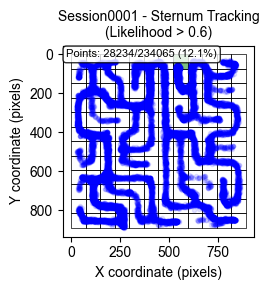

✓ Plot created for Session0001
-----------------------------
Creating grid scatter plot for Session0002...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 50822/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0002_sternum_scatter_plot.png


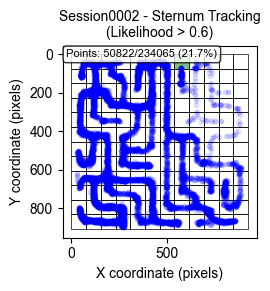

✓ Plot created for Session0002
-----------------------------
Creating grid scatter plot for Session0003...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 45360/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0003_sternum_scatter_plot.png


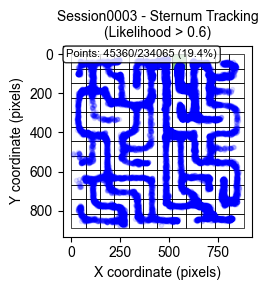

✓ Plot created for Session0003
-----------------------------
Creating grid scatter plot for Session0004...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 90516/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0004_sternum_scatter_plot.png


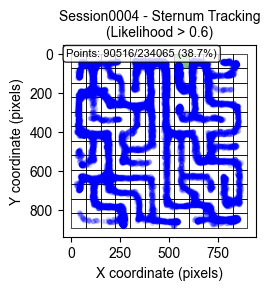

✓ Plot created for Session0004
-----------------------------
Creating grid scatter plot for Session0005...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 14706/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0005_sternum_scatter_plot.png


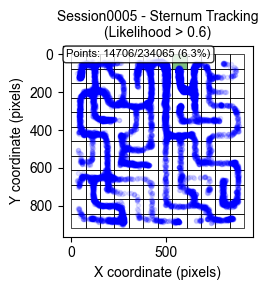

✓ Plot created for Session0005
-----------------------------
Creating grid scatter plot for Session0006...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 67810/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0006_sternum_scatter_plot.png


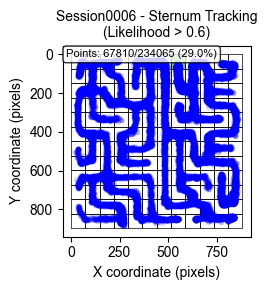

✓ Plot created for Session0006
-----------------------------
Creating grid scatter plot for Session0007...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 104266/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0007_sternum_scatter_plot.png


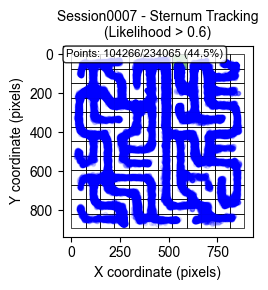

✓ Plot created for Session0007
-----------------------------
Creating grid scatter plot for Session0008...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 52997/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0008_sternum_scatter_plot.png


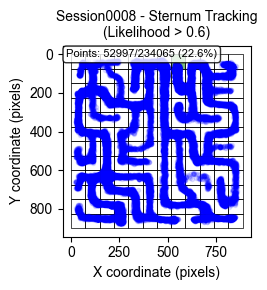

✓ Plot created for Session0008
-----------------------------
Creating grid scatter plot for Session0009...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 73480/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0009_sternum_scatter_plot.png


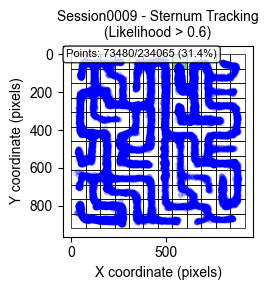

✓ Plot created for Session0009
-----------------------------
Creating grid scatter plot for Session0010...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 75621/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0010_sternum_scatter_plot.png


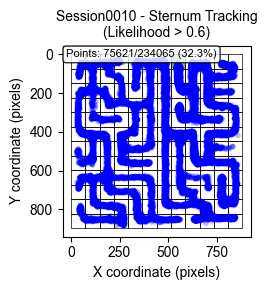

✓ Plot created for Session0010
-----------------------------
Creating grid scatter plot for Session0011...
  Loaded grid: 144 grid squares
  Loaded DLC data: 234065 frames
  Plotted 40292/234065 points above likelihood threshold
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\scatter_plots\Session0011_sternum_scatter_plot.png


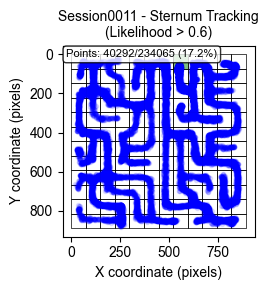

✓ Plot created for Session0011
-----------------------------
Creating grid scatter plot for Session0012...
Error: Grid file not found: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0012_grid.shp
✗ Failed to create plot for Session0012
-----------------------------
Creating grid scatter plot for Session0013...
Error: Grid file not found: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0013_grid.shp
✗ Failed to create plot for Session0013
-----------------------------
Creating grid scatter plot for Session0014...
Error: Grid file not found: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0014_grid.shp
✗ Failed to create plot for Session0014
-----------------------------
Creating grid scatter plot for Session0015...
Error: Grid file not found: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoM

In [ ]:
now = datetime.datetime.now()

print("\n--- Batch Processing Example ---")
batch_results = dlc_utils.batch_create_grid_scatter_plots(
    mouseinfo_df=mouseinfo,
    dlc_results_directory=source_data_path,
    grid_files_directory=source_data_path,
    figures_directory=figure_path,
    dlc_scorer=dlc_scorer,
    bodypart='sternum',
    likelihood_threshold=0.6,
    figure_size=(3, 3),
    show_plots=True  # Don't display plots during batch processing
)

### Create Trajectory Plots with Grid Overlaid


--- Different Colormaps Example ---

Creating trajectory plots with viridis colormap...
Creating trajectory plots for 15 sessions...
Bodypart: sternum
Likelihood threshold: 0.6
Colormap: viridis
Saving plots to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots
-----------------------------
Creating trajectory plot for Session0001...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0001_sternum_trajectory_plot.png


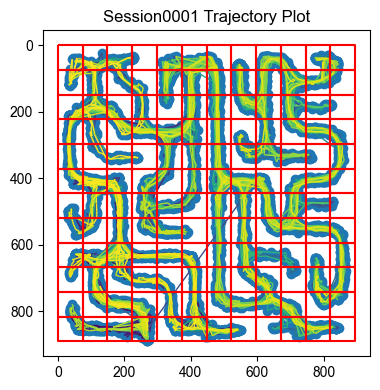

✓ Trajectory plot created for Session0001
-----------------------------
Creating trajectory plot for Session0002...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0002_sternum_trajectory_plot.png


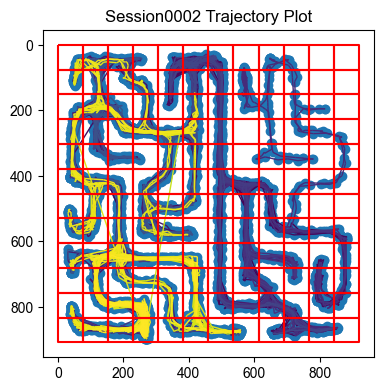

✓ Trajectory plot created for Session0002
-----------------------------
Creating trajectory plot for Session0003...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0003_sternum_trajectory_plot.png


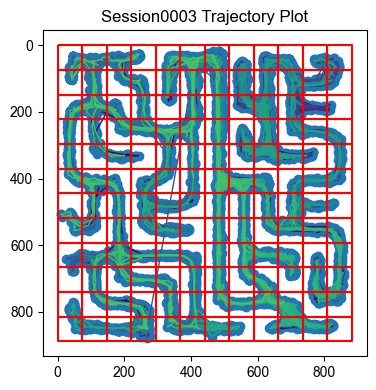

✓ Trajectory plot created for Session0003
-----------------------------
Creating trajectory plot for Session0004...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0004_sternum_trajectory_plot.png


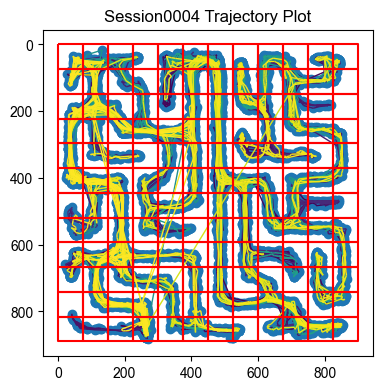

✓ Trajectory plot created for Session0004
-----------------------------
Creating trajectory plot for Session0005...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0005_sternum_trajectory_plot.png


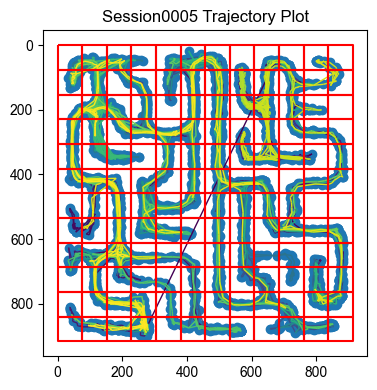

✓ Trajectory plot created for Session0005
-----------------------------
Creating trajectory plot for Session0006...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0006_sternum_trajectory_plot.png


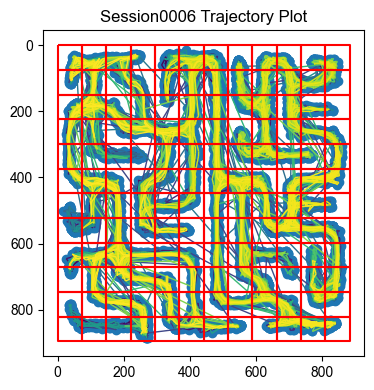

✓ Trajectory plot created for Session0006
-----------------------------
Creating trajectory plot for Session0007...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0007_sternum_trajectory_plot.png


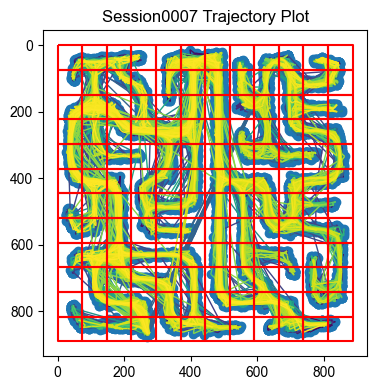

✓ Trajectory plot created for Session0007
-----------------------------
Creating trajectory plot for Session0008...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0008_sternum_trajectory_plot.png


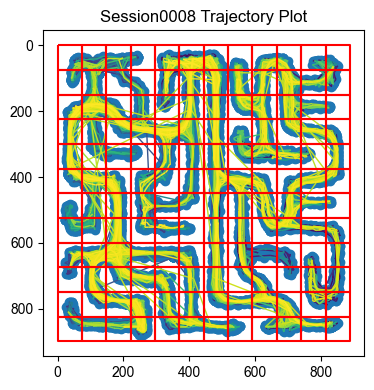

✓ Trajectory plot created for Session0008
-----------------------------
Creating trajectory plot for Session0009...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0009_sternum_trajectory_plot.png


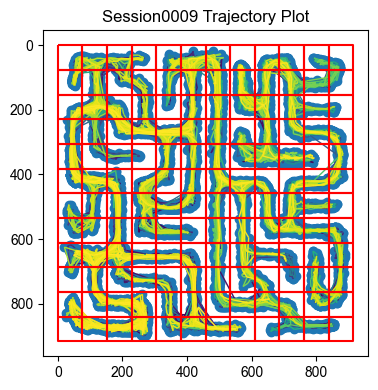

✓ Trajectory plot created for Session0009
-----------------------------
Creating trajectory plot for Session0010...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0010_sternum_trajectory_plot.png


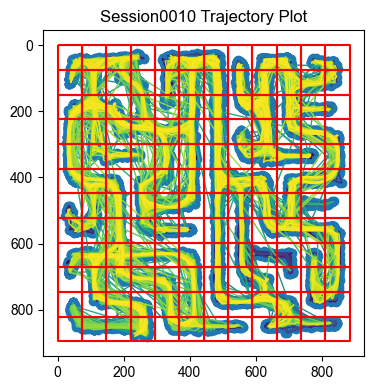

✓ Trajectory plot created for Session0010
-----------------------------
Creating trajectory plot for Session0011...
  Plot saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\figures\trajectory_plots\trajectory_plots\Session0011_sternum_trajectory_plot.png


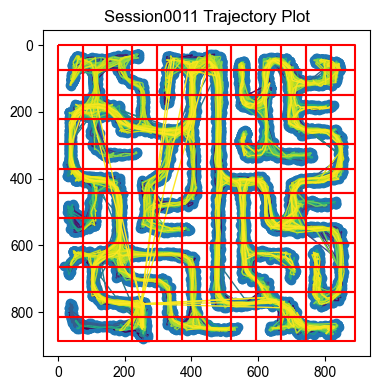

✓ Trajectory plot created for Session0011
-----------------------------
Creating trajectory plot for Session0012...
Error: Grid file not found: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0012_grid.shp
✗ Failed to create trajectory plot for Session0012
-----------------------------
Creating trajectory plot for Session0013...
Error: Grid file not found: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0013_grid.shp
✗ Failed to create trajectory plot for Session0013
-----------------------------
Creating trajectory plot for Session0014...
Error: Grid file not found: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\grid_files\Session0014_grid.shp
✗ Failed to create trajectory plot for Session0014
-----------------------------
Creating trajectory plot for Session0015...
Error: Grid file not found: D:\Gladstone Dropbox\Palop Lab\Patric

In [ ]:
now = datetime.datetime.now()

print("\n--- Different Colormaps Example ---")
colormaps = ['viridis']

for colormap in colormaps:
    print(f"\nCreating trajectory plots with {colormap} colormap...")
    batch_results = dlc_utils.batch_create_trajectory_plots(
        mouseinfo_df=mouseinfo,  # Just first 2 sessions
        dlc_results_directory=source_data_path,
        grid_files_directory=source_data_path,
        figures_directory=figure_path / f"trajectory_plots",
        dlc_scorer=dlc_scorer,
        bodypart='sternum',
        likelihood_threshold=0.6,
        colormap=colormap,
        show_plots=True
    )

# Create CSVs with Grid Numbers

In [ ]:
now = datetime.datetime.now()

results = dlc_utils.batch_append_grid_numbers(
    mouseinfo_df=mouseinfo,
    grid_files_directory=source_data_path,
    dlc_results_directory=source_data_path,
    dlc_scorer=dlc_scorer,
    save_directory=source_data_path
)

Batch grid annotation started: 2025-11-05 11:02:49.383465
Annotating 15 sessions with grid numbers...
-----------------------------
Processing Session0001 (1/15)...
Appending grids to Session0001 CSV...
Saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\dlc_results\Session0001_withGrids.csv
Grid annotation completed for Session0001
-----------------------------
Processing Session0002 (2/15)...
Appending grids to Session0002 CSV...
Saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\dlc_results\Session0002_withGrids.csv
Grid annotation completed for Session0002
-----------------------------
Processing Session0003 (3/15)...
Appending grids to Session0003 CSV...
Saved to: D:\Gladstone Dropbox\Palop Lab\Patrick\DeepLabCut Projects\AppSAA_DSI_CoMPASS_Test\data\dlc_results\Session0003_withGrids.csv
Grid annotation completed for Session0003
-----------------------------
Processing Session0004 (4/15)..